# Creating the dataset for the training

---
**USEFUL LINKS :**

The paper and its github :

https://github.com/lindawangg/COVID-Net

---

In [1]:
# !pip install pydicom

!pip install "torch==1.4" "torchvision==0.5.0" # to avoid a warning spam

In [2]:
# IMPORTS :
from fastai.vision import *

import pandas as pd
import csv

from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit

print( "Using GPU: " + str(torch.cuda.get_device_name() ) )

Using GPU: Tesla P100-PCIE-16GB


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !apt install unzip

# Unzip CovidX-v4 dataset
! unzip -q '/content/drive/My Drive/Colab Notebooks/Internship/COVID19_DATA/Covid-X-v4.zip'

print('Done!')

replace data/test_split.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Done!


In [5]:
import pathlib
path = pathlib.Path( '/content/data' )
path.ls()

bs = 64

seed = 42
np.random.seed( seed )

train_path = pathlib.Path( '/content/data/train/' )
test_path = pathlib.Path( '/content/data/test/' )

train = pd.read_csv(path/"train_split.txt", sep=' ', header=None, names=['Image','Class','Origin']).drop('Origin',axis=1)
test = pd.read_csv(path/"test_split.txt", sep=' ', header=None, names=['Image','Class', 'Origin']).drop('Origin',axis=1)

cv = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=seed)
train_idx, val_idx = next(cv.split(train['Image'],train['Class']))

data = (ImageList.from_df(train, path = train_path)
                .split_by_idxs(train_idx.tolist(), val_idx.tolist())
                .label_from_df(cols=['Class'])
                .transform(tfms=get_transforms(max_warp=0.), size=224) 
                .add_test(ImageList.from_df(test, path=test_path))
                .databunch(bs=bs, num_workers = 4)
                .normalize(imagenet_stats)
               )

['COVID-19', 'normal', 'pneumonia']


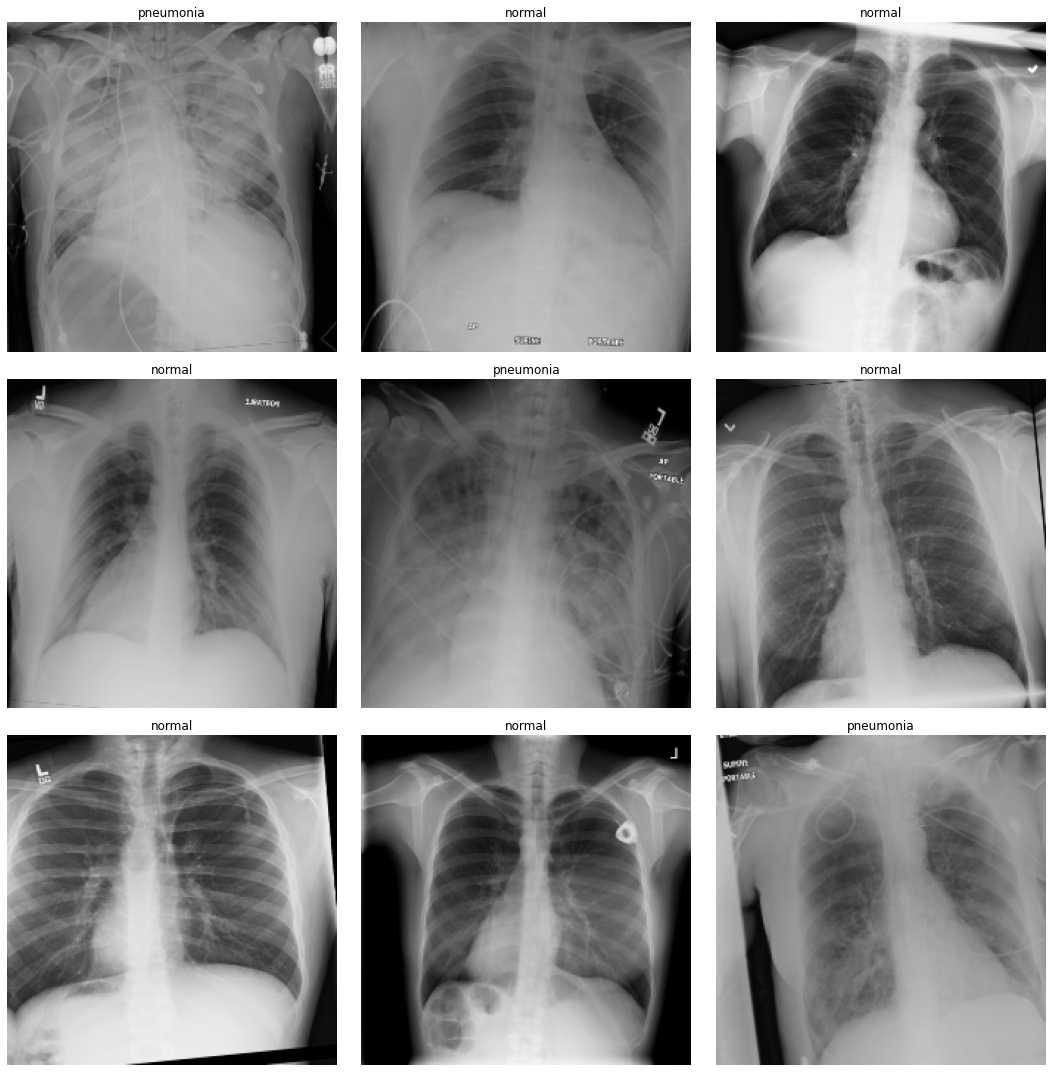

In [6]:
print(data.classes)

data.show_batch(rows=3, figsize=(15,15))

In [7]:
train

,Image,Class
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia
...,...,...
c1628c47-5ba3-42dd-8df3-7ad3abd57ad0,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,pneumonia
c1cddf32-b957-4753-acaa-472ab1447e86,c1cddf32-b957-4753-acaa-472ab1447e86.png,pneumonia
c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,pneumonia
c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,pneumonia


# Creating the model

In [8]:
from fastai.callbacks import *

mod = models.densenet201
learn = cnn_learner(data, mod, metrics=[error_rate, accuracy, Precision(), Recall()], callback_fns=[OverSamplingCallback])

# learn = Learner(data, mxresnet50(c_out=len(data.classes), sa=True), metrics=[error_rate, accuracy, Precision(), Recall()], callback_fns=[OverSamplingCallback] )

# #If we want to know the learning rate :
# learn.lr_find()
# learn.recorder.plot()

First round of learning

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.333529,0.309844,0.102878,0.897122,0.875699,0.897786,19:22
1,0.166375,0.200762,0.069784,0.930216,0.934615,0.919277,18:49
2,0.132046,0.188985,0.069784,0.930216,0.950373,0.877173,18:49
3,0.091978,0.171714,0.062590,0.937410,0.947614,0.929612,17:58
4,0.083767,0.165548,0.058273,0.941727,0.951338,0.931736,18:09


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


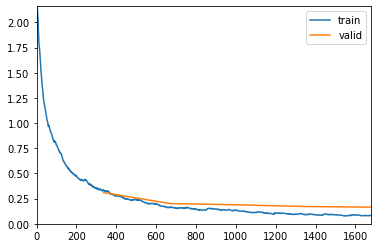

Better model found at epoch 0 with accuracy value: 0.897122323513031.
Better model found at epoch 1 with accuracy value: 0.9302158355712891.
Better model found at epoch 3 with accuracy value: 0.9374100565910339.
Better model found at epoch 4 with accuracy value: 0.9417266249656677.


PosixPath('/content/data/train/models/densenet201_v2s1.pth')

In [9]:
from fastai.callbacks import SaveModelCallback
lr = 1e-3 # using lr_find, we choose lr_max not too close from min

# Set up the learning rate (controls the step size)
learn.fit_one_cycle(5, max_lr=lr, callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='improvement', monitor='accuracy',name='model')])  # epoch = number of cycle during the training : forw & backw
learn.save('densenet201_v2s1' , return_path=True)


Second round of learning

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.077347,0.174310,0.062590,0.937410,0.947575,0.922745,18:17
1,0.071159,0.166169,0.061871,0.938129,0.949471,0.928299,17:47
2,0.073820,0.173569,0.064029,0.935971,0.953676,0.922101,17:58
3,0.062460,0.170377,0.065468,0.934532,0.952885,0.920688,18:14


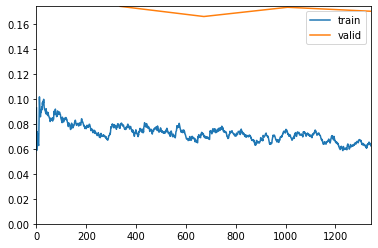

Better model found at epoch 0 with accuracy value: 0.9374100565910339.
Better model found at epoch 1 with accuracy value: 0.9381294846534729.


PosixPath('/content/data/train/models/densenet201_v2s2.pth')

In [10]:
lr2 = 1e-4

# Set up the learning rate (controls the step size)
learn.fit_one_cycle(4, max_lr=lr2, callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='improvement', monitor='accuracy',name='model')])  # epoch = number of cycle during the training : forw & backw
learn.save('densenet201_v2s2' , return_path=True)

Let's see some of the most incorrect images, we also compute accuracy and error rate although the ones we will use are the ones computed with the test data.

Accuracy tensor(0.9381)
Error Rate tensor(0.0619)


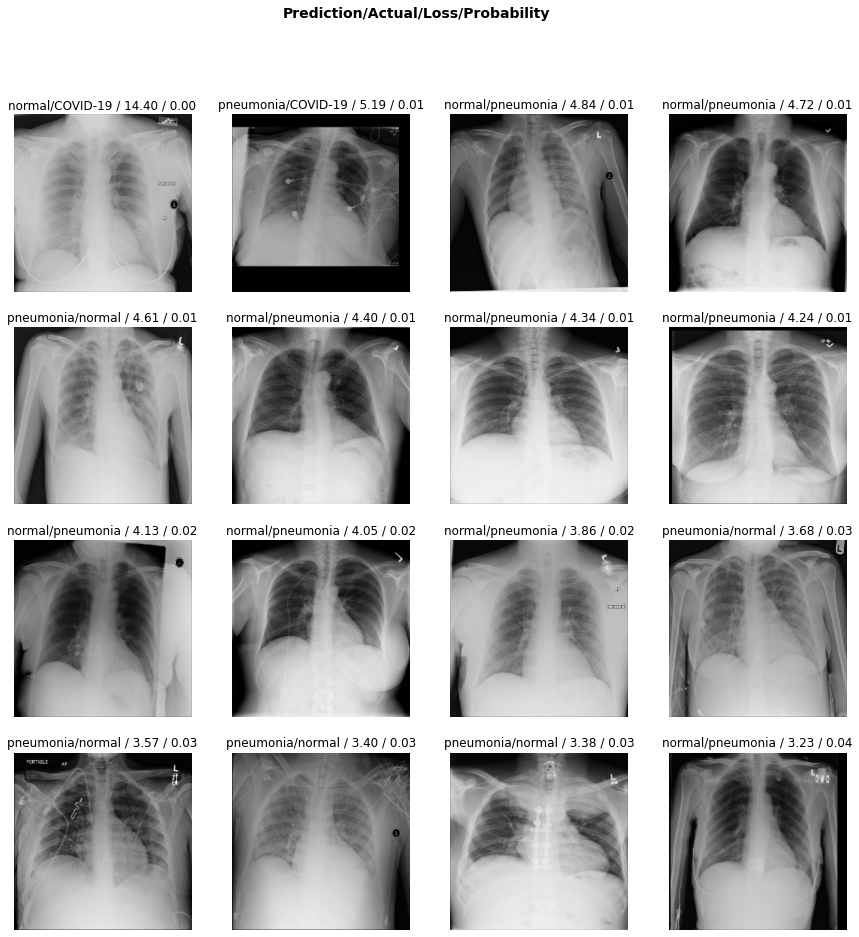

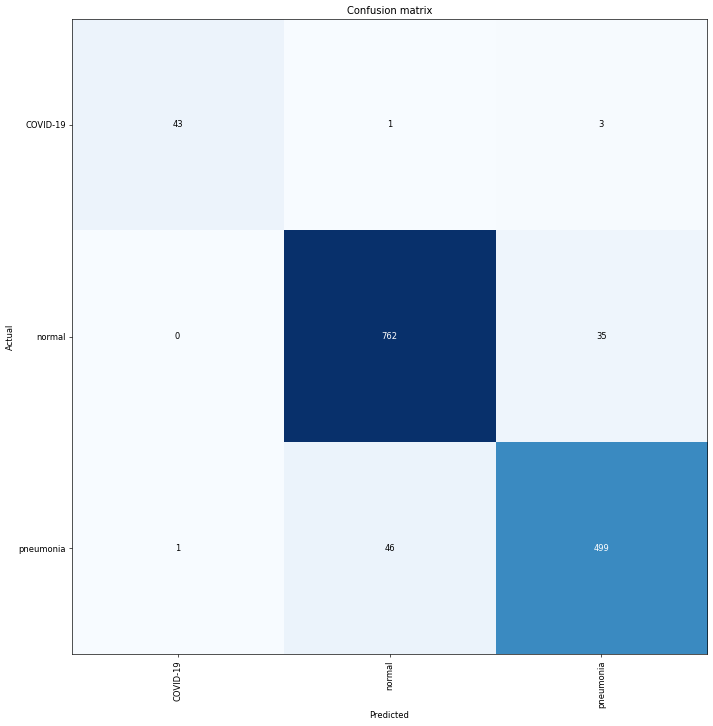

In [11]:
# What are the most incorrect ones?
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(16, figsize=(15,15)) # multi label version
# # Confusion matrix to compare the results :
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)  

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid) 
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))

# Show + test

Old version (issues with the number of images in the end) (???)

In [12]:
# df_test = pd.read_csv(path/'test_split_v3.txt', sep = ' ', header = None, usecols = [1, 2])
# df_test.head()

#  data_test = (ImageDataBunch.from_df(path, df=df_test, folder='test',fn_col=0, label_col=1)
#         .split_none()    
#         .label_from_df()) 

# data_test.valid = data_test.train

# data_test = (data_test.transform(tfms = None, size=448)
        # .databunch(bs = 16))
        # .normalize(imagenet_stats))

New version adapted from COVIDX-Fastai-XResNet18.ipynb


In [13]:
data_test = (ImageList.from_df(test, path=test_path)
            .split_none()
            .label_from_df(cols=['Class'])
            .transform(tfms=None, size=224)
            )

data_test.valid = data_test.train
data_test = data_test.databunch(bs=bs, num_workers=4).normalize(imagenet_stats)

In [14]:
# # If need to load a different model :
# mod = models.densenet169
# learn = cnn_learner(data_test, mod, metrics=[accuracy])

# learn = learn.load(Path('Densenet169_v1s2'))

learn.data.valid_dl = data_test.valid_dl

# Interpret
interp = ClassificationInterpretation.from_learner(learn)


Let's see the most incorrect images

Accuracy tensor(0.9373)
Error Rate tensor(0.0627)


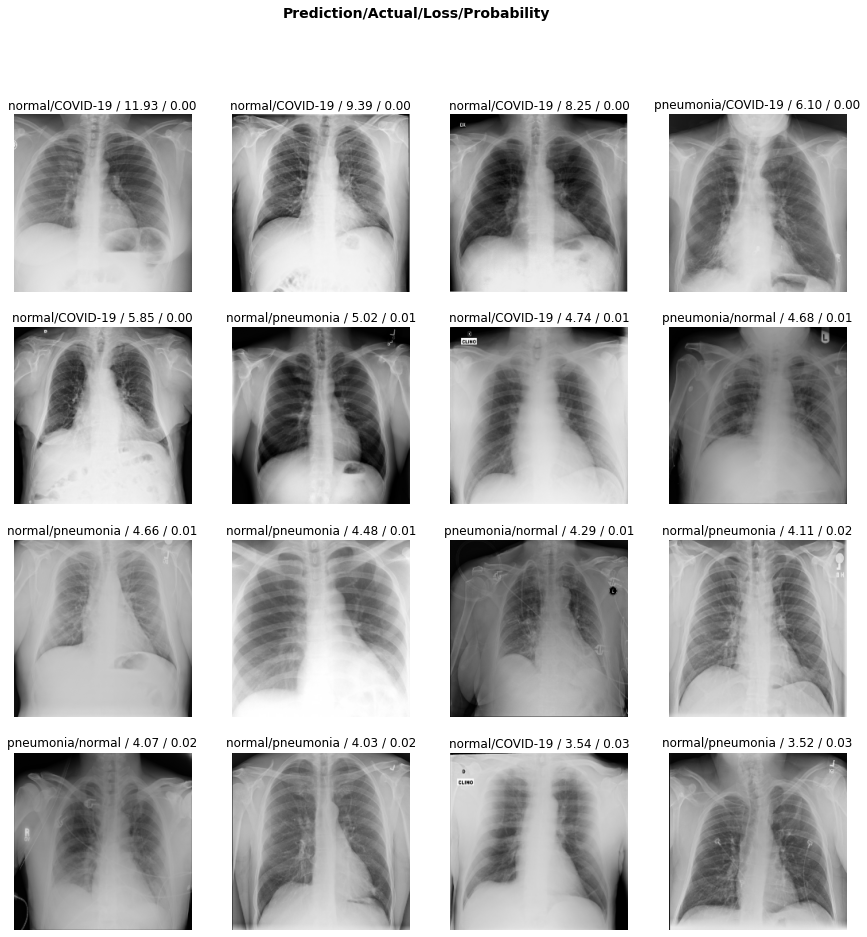

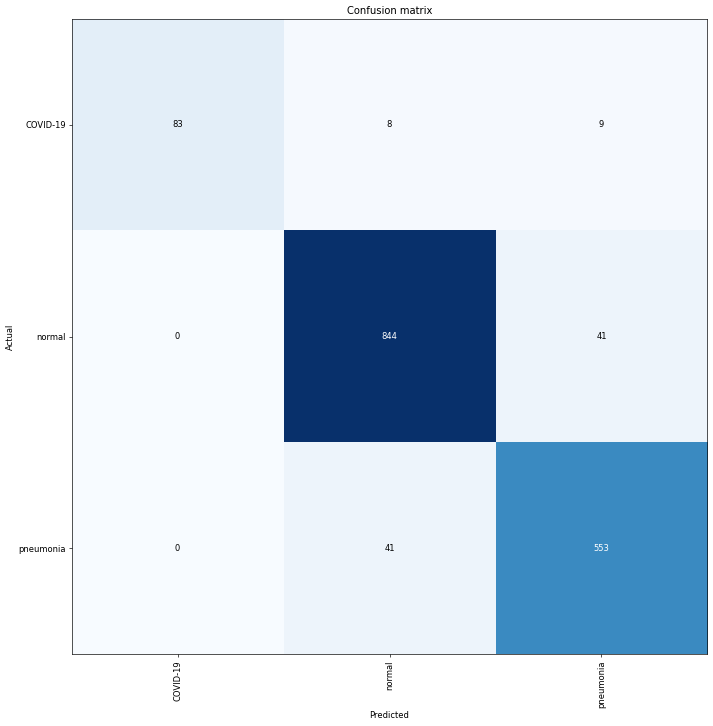

In [15]:
# What are the most incorrect ones?
interp.plot_top_losses(16, figsize=(15,15)) # multi label version
# # Confusion matrix to compare the results :
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)  

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)

print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))


Compute the recall and the Precision per class:

In [16]:
# adapted from COVIDX-Fastai-XResNet18.ipynb
# Convert dataframe test labels to list
gt = test['Class'].tolist()

# Convert from label names to class index values (0, 1, 2)
from sklearn import preprocessing
labels = data.classes
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
test_preds = le.transform( gt )

# I added this:
class_guess = probs.argmax(dim=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score( class_guess.numpy(), np.asarray( test_preds ) )
print( "Accuracy = " + str( acc ) )

# Calculate precision per class
print(data.classes)

from sklearn.metrics import precision_score
prec = precision_score( class_guess.numpy(), np.asarray( test_preds ), average=None )
print( "Precision (Positive Predictive Value) per class = " + str( prec ))

# Calculate recall per class
from sklearn.metrics import recall_score
rec = recall_score(class_guess.numpy(), np.asarray(test_preds), average=None )
print( "Recall (Sensitiviy) per class = " + str( rec ))

Accuracy = 0.9373020899303357
['COVID-19', 'normal', 'pneumonia']
Precision (Positive Predictive Value) per class = [0.83     0.953672 0.930976]
Recall (Sensitiviy) per class = [1.       0.945129 0.917081]


In [17]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (12502 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,pneumonia
Path: /content/data/train;

Valid: LabelList (1579 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/data/test;

Test: LabelList (1579 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/data/train, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      

# Recall, Accuracy, Precision, etc
https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

https://docs.fast.ai/metrics.html

Recall = sensitivity

Precision = Positive predictive value


